In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "15"

In [2]:
from keras.utils import Sequence
from keras.layers import Dense, Activation, Input, Conv1D, MaxPooling1D, Reshape
from keras.optimizers import Adam
from keras import Model
import numpy as np
from seqdataloader.batchproducers.coordbased.core import Coordinates
from seqdataloader.batchproducers.coordbased.coordstovals.fasta import PyfaidxCoordsToVals
from pyfaidx import Fasta
import random
from matplotlib import pyplot as plt
import time

In [3]:
class TrainGenerator(Sequence):
    def __init__(self):
        self.trainingfile = training_set
        self.converter = PyfaidxCoordsToVals('GRCh38.p13.genome.fa')
        self.batchsize = batchsize
        self.steps_per_epoch = train_steps
        self.total_epochs = num_epochs  # how many epochs to train for (you're using enough epochs when the loss stops going down)
        self.get_coords()
        self.on_epoch_end()
    def __len__(self):  # required by Keras -- returns # of batches to expect
        print('running __len__')
        return self.steps_per_epoch
    def get_coords(self):
        print("running get_coords(" + str(int(time.time() - start)) + "sec)")
        with open(self.trainingfile) as trainf:
            #self.labels = [int(line.split()[-6:]) for line in trainf]  # assumes last columns in file are the labels, and assumes 6 label columns
            #coords_tmp = [line.split()[:3] for line in trainf]
            #self.coords = [Coordinates(coord[0], int(coord[1]), int(coord[2])) for coord in coords_tmp]
            self.labels = []
            self.coords = []
            for line in trainf:
                temp = line.split()
                tempList = [temp[0], int(temp[1]), int(temp[2]), float(temp[3]), float(temp[4]), 
                            float(temp[5]), float(temp[6]), int(temp[7]), int(temp[8])]
                for ind in range(len(tempList)):
                    if (ind < 3 or ind > 6):
                        continue
                    if (tempList[ind] > threshold):
                        tempList[ind] = 1
                    else:
                        tempList[ind] = 0
                    #tempList[ind] = int(tempList[ind])
                self.labels.append(tempList[-6:-2]) #4 label columns
                self.coords.append(Coordinates(tempList[0], tempList[1], tempList[2]))
            #should I cast them as numpy arrays?
    def __getitem__(self, batch_index):
        #print("running __getitem__")
        ##print("running __getitem__(" + str(int(time.time() - start)) + "sec)")
        # get one-hot encoded sequences, using coordinates, for the next batch
        seqs_onehot = self.converter(self.coords[batch_index * self.batchsize : (batch_index + 1) * self.batchsize])
        # get labels for the next batch
        labels = self.labels[batch_index * self.batchsize : (batch_index + 1) * self.batchsize]
        
        if (seqs_onehot.shape[0] == 0):
            print("DEBUG: seqs_onehot.shape[0] == 0")
            print("batch_index: " + str(batch_index))
            print("self.batchsize: " + str(self.batchsize))
            print("self.coords[batch_index * self.batchsize : (batch_index + 1) * self.batchsize]")
            print(self.coords[batch_index * self.batchsize : (batch_index + 1) * self.batchsize])
        
        # sanity checks
        assert seqs_onehot.shape[0] == np.array(labels).shape[0], (seqs_onehot.shape[0], np.array(labels).shape[0])
        assert seqs_onehot.shape[0] == self.batchsize, (seqs_onehot.shape[0], self.batchsize)
        return seqs_onehot, np.array(labels) #return all_seqs, np.array(self.labels)
    def on_epoch_end(self):
        # shuffle labels and coordinates (together) between epochs
        #print("running on_epoch_end")
        print("running on_epoch_end(" + str(int(time.time() - start) // 60) + "min)")
        zipped_coords_and_labels = list(zip(self.coords, self.labels))
        random.shuffle(zipped_coords_and_labels)
        self.coords = [pair[0] for pair in zipped_coords_and_labels]
        self.labels = [pair[1] for pair in zipped_coords_and_labels]

In [4]:
def default_model(sequence_length = 200, num_filters = 240, filter_size = 20, dense1_nodes = 1024, dense2_nodes = 512, dense3_nodes = 128, num_outputs = 4, stride = 10, pool_len = 10):
    # start by defining input layer, which will read in one-hot encoded sequences
    seq_input = Input(shape = (sequence_length, 4, ), name = 'seq')
    # the first layer is convolutional
    seq = Conv1D(num_filters, filter_size, padding = "same")(seq_input)
    seq2 = Activation("relu")(seq)
    # pool to decrease size (keep strides <= pool_size)
    seq3 = MaxPooling1D(padding = "same", strides = stride, pool_size = pool_len)(seq2)
    # pyramid of dense layers with decreasing #s of nodes
    reshaped = Reshape((int(num_filters * sequence_length / stride), ))(seq3)
    dense1 = Dense(dense1_nodes, activation = "relu")(reshaped)
    dense2 = Dense(dense2_nodes, activation = "relu")(dense1)
    dense3 = Dense(dense3_nodes, activation = "relu")(dense2)
    # softmax layer output (since we are predicting multiple categories)
    # use with categorical_crossentropy loss
    output = Dense(num_outputs, activation = "softmax")(dense3)
    # return model
    model = Model(seq_input, output)
    return model

# Training Set Modification (25-25-25-25)

In [5]:
threshold = 0.75

training_set = '6col-training-set-eql75.bed'
#training_set = '6col-training-set-eql90.bed'
#training_set = '6col-training-set-mod85.bed'
#training_set = '6col-training-set-mod.bed'
#training_set = '6col-training-set.bed'

In [ ]:
with open('6col-training-set.bed', 'r') as f:
    training = f.readlines()
for i in range(len(training)):
    training[i] = training[i].split()
    for j in range(len(training[i])):
        if (j == 1 or j == 2 or j > 6):
            training[i][j] = int(training[i][j])
        elif (j > 2):
            training[i][j] = float(training[i][j])
training[:100]

In [ ]:
def reduce(file, interval, column): #file = list, interval = int, column = int
    #print(file[:100])
    print(len(file))
    counter = 0
    newList = []
    print("creating newList")
    for window in file:
        if (window[column] > threshold):
            counter += 1
            if (counter % interval == 0):
                newList.append(window)
        else:
            newList.append(window)
    #print(newList[:100])
    print("removed items")
    print(len(newList))
    #newList[:100]
    return newList

In [ ]:
def dontUseThisCountAll():
    counted = [0, 0, 0, 0]
    cTotal = 0
    counted[0] = !awk '{if ($4 > $threshold) i += 1} END {print i}' 6col-training-set.bed
    counted[1] = !awk '{if ($5 > $threshold) i += 1} END {print i}' 6col-training-set.bed
    counted[2] = !awk '{if ($6 > $threshold) i += 1} END {print i}' 6col-training-set.bed
    counted[3] = !awk '{if ($7 > $threshold) i += 1} END {print i}' 6col-training-set.bed
    for i in range(len(counted)):
        counted[i] = int(counted[i][0])
        #print(type(counted[i]))
        cTotal += counted[i]
    for item in counted:
        print(int(item) / cTotal) #percentage
    return counted #value

In [6]:
def countAll(file):
    counted = [0, 0, 0, 0]
    for x in file:
        counted[0] += int(x[3] > threshold)
        counted[1] += int(x[4] > threshold)
        counted[2] += int(x[5] > threshold)
        counted[3] += int(x[6] > threshold)
    cTotal = counted[0] + counted[1] + counted[2] + counted[3]
    for item in counted:
        print(item / cTotal)
    print(counted)
    return counted

In [ ]:
def even_out(file): #file = list
    count = countAll(file)
    minimum = min(count) #this is ingenius; I was going to actually write it out
    intervals = [0, 0, 0, 0]
    for i in range(len(intervals)):
        intervals[i] = round(float(count[i]) / minimum)
    print(intervals) #this printed [1005, 5, 1, 19]
    newList = file
    for i in range(4):
        newList = reduce(newList, intervals[i], i + 3)
    return newList

In [ ]:
#a= !awk '{if ($4 > $threshold) i += 1} END {print i}' 6col-training-set.bed
#!awk '{if ($5 > $threshold) i += 1} END {print i}' 6col-training-set.bed
#c = !awk '{if ($6 > $threshold) i += 1} END {print i}' 6col-training-set.bed
#d = !awk '{if ($7 > $threshold) i += 1} END {print i}' 6col-training-set.bed

In [ ]:
#print(a)
#print(b)
#print(c)
#print(d)

In [ ]:
newTrainingList = even_out(training)
print(len(newTrainingList))
newTrainingList

In [ ]:
countAll(newTrainingList)

In [ ]:
if os.path.isfile(training_set):
    os.remove(training_set)

myFile = open(training_set,'w')

for window in newTrainingList:
    val = [str(item) for item in window]
    myFile.write('\t'.join(val) + '\n')
myFile.close()

In [7]:
with open(training_set, 'r') as f:
    training2 = f.readlines()
for i in range(len(training2)):
    training2[i] = training2[i].split()
    for j in range(len(training2[i])):
        if (j == 1 or j == 2 or j > 6):
            training2[i][j] = int(training2[i][j])
        elif (j > 2):
            training2[i][j] = float(training2[i][j])
training2[:100]

[['chr6',
  41028294,
  41028494,
  0.0,
  0.7345679012345679,
  0.0,
  0.2654320987654321,
  0,
  1],
 ['chr6',
  41028494,
  41028694,
  0.5951903807615231,
  0.40480961923847697,
  0.0,
  0.0,
  1,
  0],
 ['chr6',
  41030294,
  41030494,
  0.565922920892495,
  0.4340770791075051,
  0.0,
  0.0,
  1,
  0],
 ['chr6',
  41030394,
  41030594,
  0.565922920892495,
  0.4340770791075051,
  0.0,
  0.0,
  1,
  0],
 ['chr6',
  41030594,
  41030794,
  0.5951903807615231,
  0.40480961923847697,
  0.0,
  0.0,
  1,
  0],
 ['chr6',
  41031994,
  41032194,
  0.5903614457831325,
  0.40963855421686746,
  0.0,
  0.0,
  1,
  0],
 ['chr6',
  41032794,
  41032994,
  0.5460122699386503,
  0.4539877300613497,
  0.0,
  0.0,
  1,
  0],
 ['chr6', 41033094, 41033294, 0.74, 0.26, 0.0, 0.0, 1, 0],
 ['chr6',
  41033594,
  41033794,
  0.704225352112676,
  0.0,
  0.0,
  0.29577464788732394,
  1,
  0],
 ['chr6',
  41033626,
  41033826,
  0.6666666666666666,
  0.0,
  0.0,
  0.3333333333333333,
  1,
  0],
 ['chr6',
  4

In [8]:
print(len(training2))
countAll(training2)

425226
0.25039760501450087
0.25105248386191414
0.25025727383291235
0.24829263729067266
[10706, 10734, 10700, 10616]


[10706, 10734, 10700, 10616]

# Sanity Check
ignore this - no longer relevant

In [ ]:
with open(training_set, 'r') as f:
    train_mod = f.readlines()
for i in range(len(train_mod)):
    train_mod[i] = train_mod[i].split()
    for j in range(len(train_mod[i])):
        if (j == 1 or j == 2 or j > 6):
            train_mod[i][j] = int(train_mod[i][j])
        elif (j > 2):
            train_mod[i][j] = float(train_mod[i][j])
train_mod[:100]

In [ ]:
#training should've been opened in the above section
counter = [0, 0, 0, 0]
countAll = 0
for x in training:
    counter[0] += int(float(x[3]) > threshold)
    counter[1] += int(float(x[4]) > threshold)
    counter[2] += int(float(x[5]) > threshold)
    counter[3] += int(float(x[6]) > threshold)
    countAll += 1

In [ ]:
counter2 = [0, 0, 0, 0]
countAll2 = 0
for x in train_mod:
    counter2[0] += int(float(x[3]) > threshold)
    counter2[1] += int(float(x[4]) > threshold)
    counter2[2] += int(float(x[5]) > threshold)
    counter2[3] += int(float(x[6]) > threshold)
countAll2 = counter2[0] + counter2[1] + counter2[2] + counter2[3]

In [ ]:
print(counter2[0]/countAll2)
print(counter2[1]/countAll2)
print(counter2[2]/countAll2)
print(counter2[3]/countAll2)

### DO NOT RUN THE CELL BELOW!!!

In [ ]:
#what I expected to get
A
B
A/B             #somewhere between 0.9 and 1
A/2
B-(A/2)
(A/2)/(B-(A/2)) #somewhere between 0.7 and 0.9

# Training!

In [ ]:
if (not (os.path.isfile('GRCh38.p13.genome.fa.gz') or os.path.isfile('GRCh38.p13.genome.fa'))):
    !wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_34/GRCh38.p13.genome.fa.gz
if (not os.path.isfile('GRCh38.p13.genome.fa') and os.path.isfile('GRCh38.p13.genome.fa.gz')):
    !gunzip GRCh38.p13.genome.fa.gz

In [9]:
training_examples = !wc -l < $training_set
training_examples = int(training_examples[0])
training_examples

425226

In [10]:
#parameters
batchsize = 200 #for now
train_steps = training_examples // batchsize
num_epochs = 10 #for now #1000
#threshold defined above

In [11]:
print(training_set) #just double-checking

6col-training-set-eql75.bed


In [14]:
model = default_model()
print(model)
model.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate=0.0000001), metrics = ["accuracy"])
print(model.summary())
start = time.time()
hist = model.fit_generator(epochs = num_epochs,  # choose how many epochs to train for (watch the loss to see when to stop)
                           steps_per_epoch = train_steps,
                           generator = TrainGenerator(),  # see above
                           use_multiprocessing = True,
                           workers = 8,  # use this to split batch processing into multiple CPUs (but don't take over the VM completely!)
                           verbose = 2)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq (InputLayer)             [(None, 200, 4)]          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 240)          19440     
_________________________________________________________________
activation_1 (Activation)    (None, 200, 240)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 240)           0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4800)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              4916224   
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

In [ ]:
#to-do after this (DO NOT RESTART KERNEL)
#check to see if test generator works
#check to see if confusion matrix works

In [15]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

In [ ]:
def plot_metrics(hist, cb = None):
    epochs = range(1, 100) #1, num_epochs + 1
    plt.figure(figsize = (12,8))
    plt.subplot(211)
    plt.plot(epochs, hist.history["accuracy"], '.-', color = '#31E080', label = "Training Accuracy")
    plt.legend()
    plt.subplot(212)
    plt.plot(epochs, hist.history["loss"], '.-', color = '#31E080', label = "Training Loss")
    plt.legend()
    plt.legend()
    plt.savefig(params.figures_path + "_metrics", dpi = 300)

In [ ]:
plot_metrics(hist)

In [16]:
hist.history

{'loss': [0.14004182815551758,
  0.14010311663150787,
  0.14041081070899963,
  0.14030897617340088,
  0.14046761393547058,
  0.14059388637542725,
  0.1405787169933319,
  0.1403840184211731,
  0.1404883861541748,
  0.14063170552253723],
 'accuracy': [0.026467544957995415,
  0.025526810437440872,
  0.02527751587331295,
  0.025242239236831665,
  0.025244589895009995,
  0.025246942415833473,
  0.02525164559483528,
  0.025291627272963524,
  0.025310441851615906,
  0.025322200730443]}

# Validation/Test Generator

In [49]:
validation_set = '6col-validation-set.bed'
test_set = '6col-test-set.bed'

In [52]:
class TestGenerator(Sequence):
    def __init__(self):
        self.testingfile = test_set
        self.converter = PyfaidxCoordsToVals('GRCh38.p13.genome.fa')
        self.batchsize = batchsize
        self.steps_per_epoch = train_steps
        self.total_epochs = num_epochs  # how many epochs to train for (you're using enough epochs when the loss stops going down)
        self.get_coords()
        self.on_epoch_end()
    def __len__(self):  # required by Keras -- returns # of batches to expect
        print('running __len__')
        return self.steps_per_epoch
    def get_coords(self):
        print("running get_coords")
        with open(self.testingfile) as testf:
            #self.labels = [int(line.split()[-6:]) for line in testf]  # assumes last columns in file are the labels, and assumes 6 label columns
            #coords_tmp = [line.split()[:3] for line in testf]
            #self.coords = [Coordinates(coord[0], int(coord[1]), int(coord[2])) for coord in coords_tmp]
            self.coords = []
            for line in testf:
                temp = line.split()
                tempList = [temp[0], int(temp[1]), int(temp[2])]
                self.coords.append(Coordinates(tempList[0], tempList[1], tempList[2]))
            #should I cast them as numpy arrays?
    def __getitem__(self, batch_index):
        ##print("running __getitem__")
        # get one-hot encoded sequences, using coordinates, for the next batch
        seqs_onehot = self.converter(self.coords[batch_index * self.batchsize : (batch_index + 1) * self.batchsize])
        
        # sanity checks
        assert seqs_onehot.shape[0] == self.batchsize
        return seqs_onehot
    def on_epoch_end(self):
        # shuffle labels and coordinates (together) between epochs
        print("running on_epoch_end")
        random.shuffle(self.coords)

In [41]:
prediction = model.predict_generator(generator = TestGenerator(),  # see above
                           use_multiprocessing = True,
                           workers = 8)  # use this to split batch processing into multiple CPUs (but don't take over the VM completely!)

running get_coords
running on_epoch_end
running __len__
running __len__
running on_epoch_end


In [48]:
print(prediction.size)
prediction

1700800


array([[0.2250703 , 0.31587446, 0.24309179, 0.21596345],
       [0.21879609, 0.32358792, 0.25067016, 0.20694582],
       [0.20701739, 0.31128842, 0.27407414, 0.20762004],
       ...,
       [0.20041926, 0.3138206 , 0.2713592 , 0.2144009 ],
       [0.20807523, 0.3087306 , 0.26645428, 0.21673986],
       [0.2124725 , 0.33845934, 0.24588688, 0.20318128]], dtype=float32)

In [ ]:
_test_set_prediction_values

In [51]:
!wc -l $test_set

1960396 6col-test-set.bed


# Confusion Matrix

In [53]:
#note: the matrix below is NOT the correct one

In [30]:
from sklearn.metrics import confusion_matrix

In [31]:
y_true = ["intron", "CDS", "CDS", "5' UTR", "CDS", "CDS", "CDS", "5' UTR", "5' UTR", "3' UTR", "3' UTR", "CDS", "3' UTR", "5' UTR", "5' UTR", "intron", "CDS", "3' UTR", "5' UTR"]
y_pred = ["3' UTR", "CDS", "3' UTR", "CDS", "5' UTR", "CDS", "intron", "3' UTR", "CDS", "intron", "intron", "3' UTR", "intron", "CDS", "5' UTR", "CDS", "3' UTR", "5' UTR", "5' UTR"]
myLabels = ["intron", "CDS", "5' UTR", "3' UTR"]
cm = confusion_matrix(y_true, y_pred, labels=myLabels)
cm

array([[0, 1, 0, 1],
       [1, 2, 1, 3],
       [0, 3, 2, 1],
       [3, 0, 1, 0]])

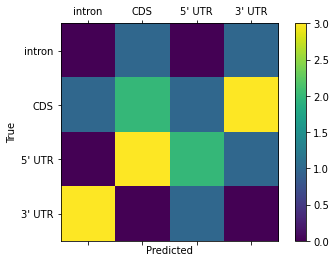

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)
ax.set_xticklabels([''] + myLabels)
ax.set_yticklabels([''] + myLabels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()